
# Assignment: Dimensionality Reduction and Classification Using the Dry Bean Dataset

This notebook is a **starter code template** for the assignment:

> *Dimensionality Reduction and Classification Using the Dry Bean Dataset*

Please read the assignment document carefully.  
You **must**:
- Implement **PCA** and **LDA** from scratch (NumPy or Scipy only).
- Implement **K-NN** and a **Gaussian Bayesian classifier** from scratch (NumPy or Scipy only).
- Use the **provided** `drybean_train.csv` and `drybean_test.csv` files **without reshuffling or re-splitting**.
- Run experiments for **d = 2, 3, 4** with both PCA and LDA.
- Report test accuracies for **K-NN** and **Bayesian classifier** on each setting.
- Visualize 2D PCA and LDA projections.


In [26]:
import numpy as np
import pandas as pd
from typing import Tuple



## 1. Load the Provided Train/Test Data

The instructor will provide two CSV files:

- `drybean_train.csv` (80% of data)
- `drybean_test.csv` (20% of data)

You **must** use these files as-is.


In [27]:
TRAIN_PATH = "/content/drybean_train.csv"
TEST_PATH = "/content/drybean_test.csv"
LABEL_COLUMN = None

def load_drybean_data(train_path, test_path, label_column=None):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    if label_column is None:
        X_train = train_df.iloc[:, :-1].to_numpy()
        y_train = train_df.iloc[:, -1].to_numpy()
        X_test = test_df.iloc[:, :-1].to_numpy()
        y_test = test_df.iloc[:, -1].to_numpy()
    else:
        X_train = train_df.drop(columns=[label_column]).to_numpy()
        y_train = train_df[label_column].to_numpy()
        X_test = test_df.drop(columns=[label_column]).to_numpy()
        y_test = test_df[label_column].to_numpy()

    unique_labels, y_train_int = np.unique(y_train, return_inverse=True)
    label_map = {lab: i for i, lab in enumerate(unique_labels)}
    y_test_int = np.array([label_map[lab] for lab in y_test])

    return X_train.astype(float), y_train_int, X_test.astype(float), y_test_int, label_map

X_train_raw, y_train, X_test_raw, y_test, label_map = load_drybean_data(TRAIN_PATH, TEST_PATH)


In [28]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive



## 2. Standardization

Standardize features (zero mean, unit variance) **using statistics from the training set only**.


In [29]:
def fit_standard_scaler(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std[std == 0] = 1.0
    return mean, std

def transform_standard_scaler(X, mean, std):
    return (X - mean) / std

mean_train, std_train = fit_standard_scaler(X_train_raw)
X_train = transform_standard_scaler(X_train_raw, mean_train, std_train)
X_test = transform_standard_scaler(X_test_raw, mean_train, std_train)



## 3. Data Preprocessing (Optional)

If you wish to perform additional pre-processing beyond standardization, you may do so in this section. Only pre-processing methods covered in class are allowed. Furthermore, pre-processing functions provided by scikit-learn are not allowed. You must implement any pre-processing step from scratch using NumPy or SciPy.

There are no missing values or duplicated samples in the dataset, so you do not need to handle them. As stated in the instructions, a small bonus score will be awarded to students who achieve exceptionally high performance.


## 4. PCA Implementation (from scratch)

Implement PCA using the covariance matrix and eigenvalue decomposition.

In [30]:
def pca_fit(X):
    N, D = X.shape
    Xc = X - X.mean(axis=0)
    C = (Xc.T @ Xc) / (N - 1)
    evals, evecs = np.linalg.eigh(C)
    idx = np.argsort(evals)[::-1]
    return evecs[:, idx], evals[idx]

def pca_transform(X, components, d):
    return X @ components[:, :d]


## 5. LDA Implementation (from scratch)

Implement Linear Discriminant Analysis for multi-class classification.


In [31]:
def lda_fit(X, y, n_classes):
    N, D = X.shape
    mu = X.mean(axis=0)
    Sw = np.zeros((D, D))
    Sb = np.zeros((D, D))

    for c in np.unique(y):
        Xc = X[y == c]
        Nc = len(Xc)
        mu_c = Xc.mean(axis=0)
        Sw += (Xc - mu_c).T @ (Xc - mu_c)
        diff = (mu_c - mu).reshape(-1, 1)
        Sb += Nc * diff @ diff.T

    Sw_inv = np.linalg.pinv(Sw)
    M = Sw_inv @ Sb
    evals, evecs = np.linalg.eig(M)
    idx = np.argsort(evals)[::-1]
    return evecs[:, idx].real, evals[idx]

def lda_transform(X, W, d):
    return X @ W[:, :d]


## 6. K-NN Classifier (from scratch)

Implement a simple K-Nearest Neighbors classifier using Euclidean distance.
You will later use **cross-validation on the training set** to select the best K.


In [32]:
class KNNClassifier:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X):
        dists = np.sqrt(((X[:, None, :] - self.X[None, :, :])**2).sum(axis=2))
        knn_idx = np.argpartition(dists, self.k, axis=1)[:, :self.k]
        preds = [np.bincount(self.y[row]).argmax() for row in knn_idx]
        return np.array(preds)


def cross_validate_knn(X, y, k_values, num_folds=5):
    N = len(X)
    idx__ = np.arange(N)
    np.random.shuffle(idx__)
    fold_size = N // num_folds

    best_k__ = None
    best_acc__ = -1

    i = 0
    while True:
        k = k_values[i]
        accs__ = []

        for f in range(num_folds):
            start = f * fold_size
            end = start + fold_size

            val_idx = idx__[start:end]
            train_idx = np.concatenate([idx__[:start], idx__[end:]])

            Xtr, ytr = X[train_idx], y[train_idx]
            Xv, yv = X[val_idx], y[val_idx]

            d = np.sqrt(((Xv[:, None, :] - Xtr[None, :, :])**2).sum(axis=2))
            neigh = np.argpartition(d, k, axis=1)[:, :k]
            pred = np.array([np.bincount(ytr[row]).argmax() for row in neigh])

            accs__.append((pred == yv).mean())

        avg_acc = np.mean(accs__)

        if avg_acc > best_acc__:
            best_acc__ = avg_acc
            best_k__ = k

        i += 1
        if i >= len(k_values):
            break

    return best_k__


## 7. Gaussian Bayesian Classifier

Assume class-conditional likelihoods are multivariate Gaussians with class-specific mean and covariance.


In [33]:
class GaussianBayesClassifier:
    def __init__(self, num_classes):
        self.C = num_classes

    def fit(self, X, y):
        N, D = X.shape
        self.means = np.zeros((self.C, D))
        self.cov = np.zeros((self.C, D, D))
        self.priors = np.zeros(self.C)

        for c in range(self.C):
            Xc = X[y == c]
            Nc = len(Xc)
            self.priors[c] = Nc / N
            self.means[c] = Xc.mean(axis=0)
            cov = np.cov(Xc.T, bias=False)
            cov += np.eye(D)*1e-6
            self.cov[c] = cov

    def predict(self, X):
        N = len(X)
        scores = np.zeros((N, self.C))
        for c in range(self.C):
            diff = X - self.means[c]
            inv = np.linalg.inv(self.cov[c])
            _, logdet = np.linalg.slogdet(self.cov[c])
            scores[:, c] = -0.5*(np.sum(diff @ inv * diff, axis=1) + logdet)
            scores[:, c] += np.log(self.priors[c])
        return np.argmax(scores, axis=1)


## 8. Experimental Pipeline

For each target dimension d in {2, 3, 4}:
1. Fit PCA on training data, transform train & test.
2. Fit LDA on training data, transform train & test.
3. For each (PCA, LDA) representation:
   - Use cross-validation on training set to choose best K for K-NN.
   - Train K-NN with best K and evaluate test accuracy.
   - Train Gaussian Bayes classifier and evaluate test accuracy.
4. Store all results in a structured dictionary or DataFrame.

CAUTION: DO NOT MODIFY THIS CODE. THIS CODE IS FOR EVALUATION OF YOUR CODE!!

IF YOU MODIFY THIS CODE, I WILL GIVE 0 PTS FOR YOUR EXPERIMENT PARTS!!


In [34]:
TARGET_DIMS = [2, 3, 4]

def run_experiments(X_train: np.ndarray, y_train: np.ndarray,
                    X_test: np.ndarray, y_test: np.ndarray,
                    k_values=(1, 3, 5, 10, 20, 50, 100)):
    num_classes = len(np.unique(y_train))
    print("Number of classes:", num_classes)

    # Fit PCA once on full train set
    components_pca, evals_pca = pca_fit(X_train)
    # Fit LDA once
    W_lda, evals_lda = lda_fit(X_train, y_train, num_classes)

    results = []
#
    for d in TARGET_DIMS:
        # PCA
        X_train_pca = pca_transform(X_train, components_pca, d=d)
        X_test_pca = pca_transform(X_test, components_pca, d=d)

        # LDA
        X_train_lda = lda_transform(X_train, W_lda, d=d)
        X_test_lda = lda_transform(X_test, W_lda, d=d)

        # K-NN on PCA
        best_k_pca = cross_validate_knn(X_train_pca, y_train, k_values=k_values)
        knn_pca = KNNClassifier(k=best_k_pca)
        knn_pca.fit(X_train_pca, y_train)
        y_pred_knn_pca = knn_pca.predict(X_test_pca)
        acc_knn_pca = (y_pred_knn_pca == y_test).mean()

        # K-NN on LDA
        best_k_lda = cross_validate_knn(X_train_lda, y_train, k_values=k_values)
        knn_lda = KNNClassifier(k=best_k_lda)
        knn_lda.fit(X_train_lda, y_train)
        y_pred_knn_lda = knn_lda.predict(X_test_lda)
        acc_knn_lda = (y_pred_knn_lda == y_test).mean()

        # Bayesian on PCA
        bayes_pca = GaussianBayesClassifier(num_classes)
        bayes_pca.fit(X_train_pca, y_train)
        y_pred_bayes_pca = bayes_pca.predict(X_test_pca)
        acc_bayes_pca = (y_pred_bayes_pca == y_test).mean()

        # Bayesian on LDA
        bayes_lda = GaussianBayesClassifier(num_classes)
        bayes_lda.fit(X_train_lda, y_train)
        y_pred_bayes_lda = bayes_lda.predict(X_test_lda)
        acc_bayes_lda = (y_pred_bayes_lda == y_test).mean()

        # Collect results
        results.append({
            "d": d,
            "acc_knn_pca": acc_knn_pca,
            "acc_knn_lda": acc_knn_lda,
            "acc_bayes_pca": acc_bayes_pca,
            "acc_bayes_lda": acc_bayes_lda,
        })

    results_df = pd.DataFrame(results)
    return results_df

# Example usage (after you load & standardize X_train_raw/X_test_raw):
mean_train, std_train = fit_standard_scaler(X_train_raw)
X_train = transform_standard_scaler(X_train_raw, mean_train, std_train)
X_test = transform_standard_scaler(X_test_raw, mean_train, std_train)
results_df = run_experiments(X_train, y_train, X_test, y_test)
results_df


Number of classes: 7


,d,acc_knn_pca,acc_knn_lda,acc_bayes_pca,acc_bayes_lda
0,2,0.870731,0.836210,0.869996,0.785898
1,3,0.882483,0.911127,0.879545,0.910393
2,4,0.891296,0.915902,0.886155,0.908189



## 9. Visualization for d = 2

After you implement PCA and LDA, generate 2D scatter plots for **d = 2**:

- PCA (PC1 vs PC2)
- LDA (LD1 vs LD2)

Color the points by their class labels. You may plot either the training set or both train + test.


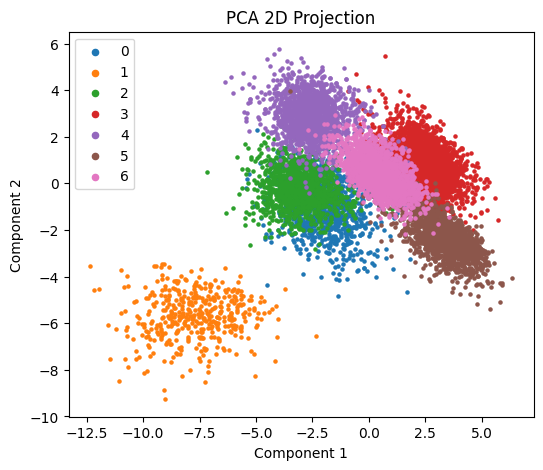

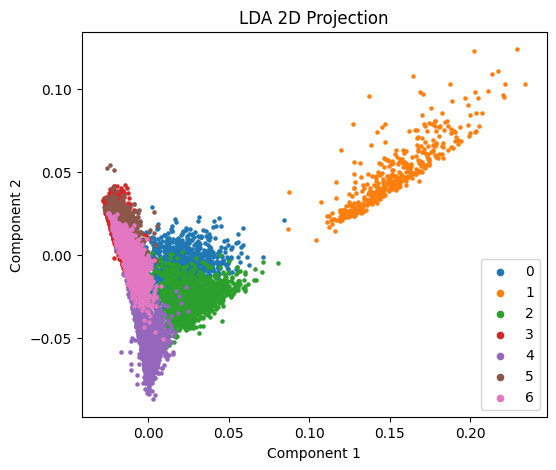

In [35]:
def plot_2d_projection(X_2d, y, title):
    import matplotlib.pyplot as plt
    classes = np.unique(y)
    plt.figure(figsize=(6,5))
    for c in classes:
        mask = (y == c)
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=5, label=str(c))
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(markerscale=2)
    plt.show()

components_pca, _ = pca_fit(X_train)
W_lda, _ = lda_fit(X_train, y_train, len(np.unique(y_train)))

X_train_pca_2d = pca_transform(X_train, components_pca, 2)
X_train_lda_2d = lda_transform(X_train, W_lda, 2)

plot_2d_projection(X_train_pca_2d, y_train, "PCA 2D Projection")
plot_2d_projection(X_train_lda_2d, y_train, "LDA 2D Projection")
